# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [27]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.nn import GraphConv,SumPooling,GINConv,AvgPooling,MaxPooling
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.spatial import ConvexHull
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse

## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [28]:
num_dfs = 50
dfs = []
for i in range(num_dfs):
    try:
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/naive_CFD_Feb_10_50events_run_1_{i}.csv")
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
if(len(dfs) > 1):
    data = pd.concat(dfs)
else:
    data = dfs[0]

skipping file #35...


## **Isolate hits in one section of detector**

Because we sometimes get backscattering and other weird detector effects, we want to train the GNN on a cluster of events that are all together, and treat hits that are far away as noise. This implementation allows the user to set how far away the hits can be and still be clustered together

In [29]:
# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 40)

## **Define the dataset class for easy management**

The HitDataset class inherits from the DGLDataset. The required member functions are the init method, process, getitem, and len.

In [30]:
dataset = HitDataset(modified_df,True,connection_mode = "kNN",k = 6)
print("done")

done


## **Optionally, we can visualize any of the input graphs below**

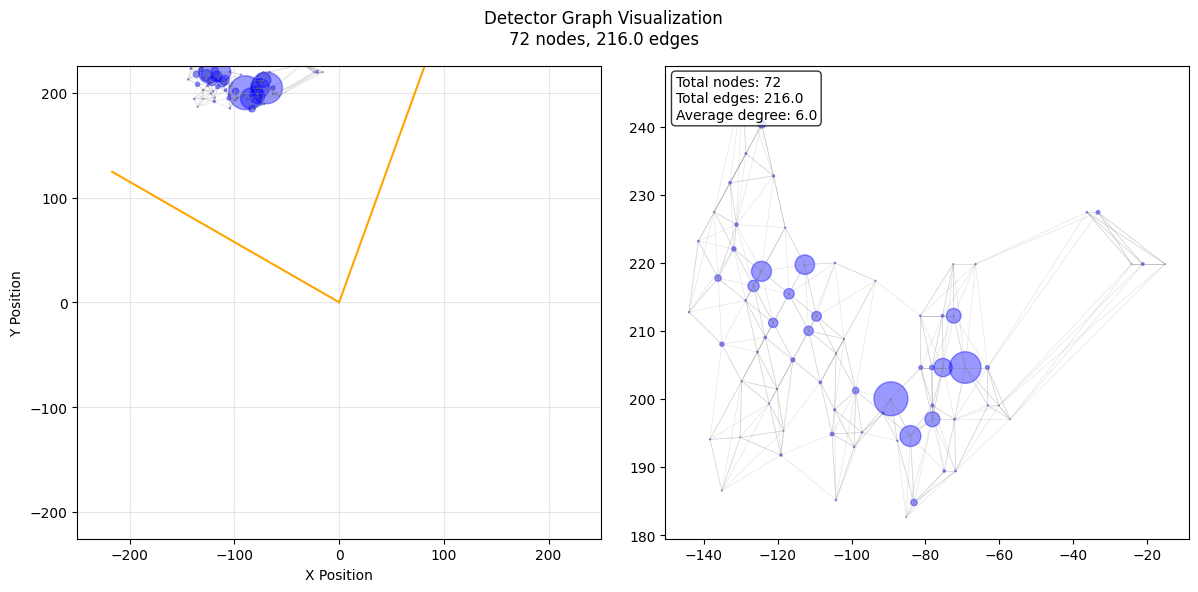

In [31]:
visualize_detector_graph(dataset,graph_idx = 4)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [32]:
train_frac = 0.7
val_frac = 0.15
num_train = int(np.floor(len(dataset) * train_frac))
# num_train = 5
num_val = int(np.floor(len(dataset) * val_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_val + num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_val + num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

## **Initialize the model and define the optimizer/criterion**

In [33]:
run_num = 1
geometry_type = 2

1. MLP hidden dim = 43
1. linear capacity = 3
1. linear layers = 7
1. conv layers = 1
1. lr = 4e-4

In [34]:
# original hyperparams with MSE ~0.11 on 200 files, geometry_type 2, K_L
# hidden_dim = 32
# lr = 1e-4
# batch_size = 20
# n_conv_layers = 2
# n_linear_layers = 7
# linear_capacity = 5
# early_stopping_limit = 3
# pooling = "avg"

# hyperparams from study 2/12/2025, 5:45pm - seems pretty good, model is ~300kb in size
# achieves MSE of 0.106
hidden_dim = 43
linear_capacity = 5
early_stopping_limit = 5
n_conv_layers = 1
n_linear_layers = 7
lr = 4e-4

In [35]:
model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats,n_conv_layers = n_conv_layers, n_linear_layers = n_linear_layers,linear_capacity = linear_capacity)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

*Now we can actually train the model*

In [36]:
model_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/models/{current_date}/"

In [37]:
n_epochs = 300
trained_model, train_losses, val_losses, optimizer,best_epoch = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit, model_path = model_path)

Epoch 1/300 - Train loss:	 0.8636
Epoch 1/300 - Validation MSE:	 0.3733

Epoch 2/300 - Train loss:	 0.3797
Epoch 2/300 - Validation MSE:	 0.2318

Epoch 3/300 - Train loss:	 0.2370
Epoch 3/300 - Validation MSE:	 0.2234

Epoch 4/300 - Train loss:	 0.2228
Epoch 4/300 - Validation MSE:	 0.2078

Epoch 5/300 - Train loss:	 0.1787
Epoch 5/300 - Validation MSE:	 0.1554

Epoch 6/300 - Train loss:	 0.2120
Epoch 6/300 - Validation MSE:	 0.2786

Test loss increased, adding uptick
Epoch 7/300 - Train loss:	 0.1751
Epoch 7/300 - Validation MSE:	 0.2507

Test loss increased, adding uptick
Epoch 8/300 - Train loss:	 0.1491
Epoch 8/300 - Validation MSE:	 0.1548

Epoch 9/300 - Train loss:	 0.1570
Epoch 9/300 - Validation MSE:	 0.1651

Test loss increased, adding uptick
Epoch 10/300 - Train loss:	 0.1528
Epoch 10/300 - Validation MSE:	 0.2037

Test loss increased, adding uptick
Epoch 11/300 - Train loss:	 0.1454
Epoch 11/300 - Validation MSE:	 0.1439

Epoch 12/300 - Train loss:	 0.1249
Epoch 12/300 - Val

/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/GNN_util.py:494: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stoppi

## **Plot training and val loss on log scale**

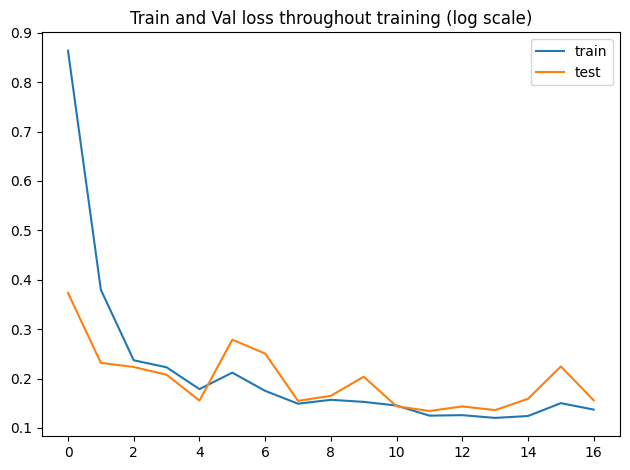

In [38]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

MSE: 0.12888702750205994


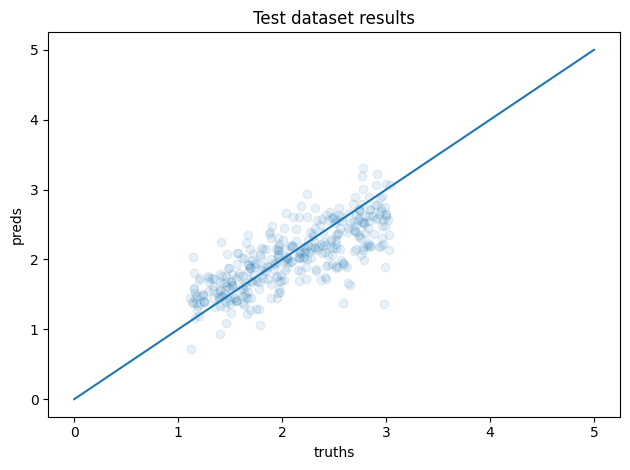

In [39]:
test_truths, test_preds, test_rmse = test_GNN(trained_model, test_dataloader)

plot.plot([0,5],[0,5])
plot.title("Test dataset results")
plot.scatter(test_truths,test_preds,alpha = 0.1)
plot.xlabel("truths")
plot.ylabel("preds")
plot.tight_layout()


1. All event feats, No charge info: 0.1701
1. All event feats, No time info:  0.1299
1. No event feats, yes charge/time, avg pooling: 0.4533
1. No event feats, yes charge/time, sum pooling: 0.1824
1. No event feats, yes charge/time, max pooling: 0.2278
1. All event feats, yes charge/time, sum pooling: 0.1657
1. (Regular) All event feats, yes charge/time, avg pooling: 0.1208

#### feature comparison
All have same model, lr
1. kNN connecting with k = 6
1. MLP hidden dim = 32
1. early stopping limit = 3
1. lr = 1e-4
1. n_conv_layers = 2
1. n_linear_layers = 7
1. linear_capacity = 5
total num params: 

| Charge 0 | Charge 1 | Time 0 | Time 1 |  strip_x | strip_y  | radial_distance  | Total Charge | Max Charge | # hits | Pooling Type | **MSE**|
|----------|----------|--------|--------|----------|----------|------------------|--------------|------------|--------|--------------|--------|
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         yes      |    yes       |  yes       |   yes  |  avg         | 0.1178 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1208 |
| yes      |   yes    |   no   |  no    | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1299 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  avg         | 0.1657 | 
| no       |   no     |   yes  |  yes   | yes      | yes      |         no       |    yes       |  yes       |   yes  |  sum         | 0.1701 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  sum         | 0.1824 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  avg         | 0.4533 |
| yes      |   yes    |   yes  |  yes   | yes      | yes      |         no       |    no        |  no        |   no   |  max         | 0.2278 |


#### Edge connecting
| Method |     k/max distance   | **MSE** |
|--------|----------------------|---------|
| max    | 100 (fully connected)| 0.1228  |
| max    | 30 (medium)          | 0.1661  |
| max    | 10 (sparse)          | 0.1515  |
| kNN    | 3 (low)              | 0.1203  |
| kNN    | 6 (med-low) (default)| 0.1135  |
| kNN    | 9 (medium high)      | 0.1217  |
| kNN    | 24 (high)            | 0.1437  |


#### New model params from hyperparam study
Trying new model with these params:
[I 2025-02-12 17:18:00,559] Trial 7 finished with value: 0.09892290830612183 and parameters: {'MLP_hidden_dim': 43, 'linear_capacity': 3, 'n_linear_layers': 7, 'n_conv_layers': 1, 'lr': 0.0004265157255271877}
1. MLP hidden dim = 43
1. linear capacity = 3
1. linear layers = 7
1. conv layers = 1
1. lr = 4e-4
  

# Binned RMSE

In [118]:
def calculate_bin_rmse(test_dataloader, model, bin_width=0.5, bin_min=1.0, bin_max=3.0):
    # Calculate the bin centers
    bin_centers = np.arange(bin_min + bin_width / 2, bin_max, bin_width)
    
    # Initialize dictionaries to store squared errors and counts per bin
    summed_sqe_per_bin = {bin_center: 0.0 for bin_center in bin_centers}
    bin_counts = {bin_center: 0 for bin_center in bin_centers}
    
    # Initialize lists to store predictions and truths
    preds = []
    truths = []
    
    # Process each batch of test data
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                labels_w_event_feats = labels[i]
                label = labels_w_event_feats[0].item()
                event_feats = labels_w_event_feats[1:].unsqueeze(0)
                pred = model(graph, graph.ndata["feat"].float(),event_feats).detach().numpy()

                # Store predictions and truths
                preds.append(pred)
                truths.append(label)
                
                # Calculate the squared error
                squared_error = (pred - label) ** 2
                
                # Find the bin this label falls into and update corresponding squared error and count
                for bin_center in bin_centers:
                    bin_min_edge = bin_center - bin_width / 2
                    bin_max_edge = bin_center + bin_width / 2
                    if bin_min_edge <= label < bin_max_edge:
                        summed_sqe_per_bin[bin_center] += squared_error
                        bin_counts[bin_center] += 1
                        break  # Only assign to one bin
    
    # Calculate RMSE for each bin
    rmse_per_bin = {}
    for bin_center in bin_centers:
        if bin_counts[bin_center] > 0:  # Avoid division by zero if no predictions fall into the bin
            rmse_value = np.sqrt(summed_sqe_per_bin[bin_center] / bin_counts[bin_center])
            rmse_per_bin[bin_center] = float(rmse_value[0,0])  # Ensure it's a scalar
        else:
            rmse_per_bin[bin_center] = float('nan')  # Assign NaN if no predictions fall into the bin
    
    return rmse_per_bin

In [119]:
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [120]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [121]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

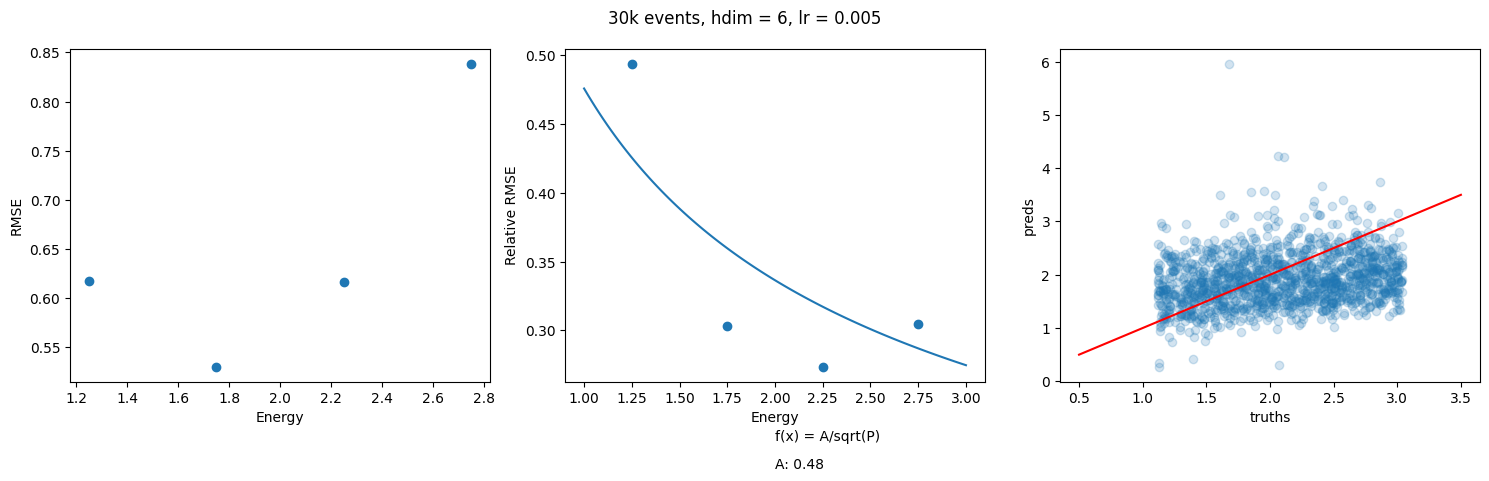

In [122]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("30k events, hdim = 6, lr = 0.005")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Energy",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Energy",ylabel = "Relative RMSE")
axs[1].text(2,0.2,f"A: {params[0]:.2f}")
axs[1].text(2,0.22,f"f(x) = A/sqrt(P)")
axs[2].scatter(test_truths,test_preds,alpha = 0.2)
axs[2].plot([0.5,3.5],[0.5,3.5],color = "red")
axs[2].set(xlabel = "truths",ylabel = "preds")
fig.tight_layout()
# plot.savefig(f"plots/GNN/run_{run_num}_RMSE_k_6.pdf")

In [28]:
from PIL import Image
import imageio

# List of JPEG files (make sure they are in order)
jpeg_files = []
for i in range(27):
    jpeg_files.append(f"plots/training_gif_frames/sipm_connected/frame{i}.jpeg")

# Load images
images = [Image.open(f) for f in jpeg_files]

# Save as a GIF
output_gif = "plots/GNN/rmse_sipmconnected.gif"
imageio.mimsave(output_gif, images, format="GIF", duration=5)  # duration in seconds

print(f"GIF saved as {output_gif}")


GIF saved as plots/GNN/rmse_sipmconnected.gif


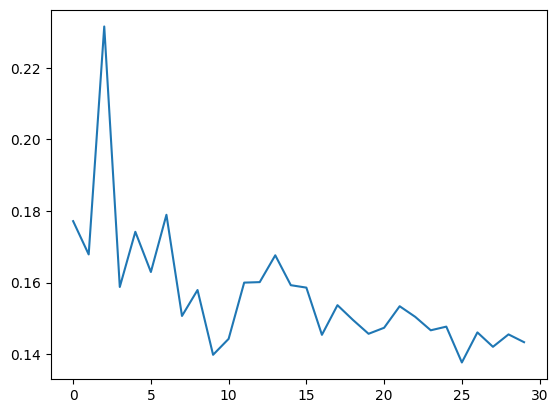

In [26]:
MSEs = [0.17717400193214417,0.1678737998008728,0.23156052827835083,0.15878933668136597,0.1741972714662552,0.16296562552452087,0.17895272374153137,0.15068310499191284,0.15792962908744812,0.13983054459095,0.14428730309009552,0.1599980592727661,0.16013631224632263,0.16763149201869965,0.15927718579769135,0.158600851893425,0.1454096883535385,0.1536991447210312,0.1495582014322281,0.14570064842700958,0.14738304913043976,0.15340179204940796,0.1504400372505188,0.1466798335313797,0.14770115911960602,0.1376865804195404,0.14609375596046448,0.14206574857234955,0.14553333818912506,0.1433575600385666]
plot.plot(MSEs)